---
# **Road Image Segmentation on the comma10k Dataset**
---

**Imports**

In [13]:
# Import Libraries
import torch
import torchmetrics
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from pathlib import Path
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import datetime
from IPython.display import clear_output, display
from base64 import b64encode
from IPython.display import HTML

**Device and Directory**

In [14]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Dataset paths
images_dir = "C:/Users/matvell/Downloads/comma10k/comma10k/images/"
masks_dir = "C:/Users/matvell/Downloads/comma10k/comma10k/masks/"

cpu


**Dataset**

In [15]:
# Initialize constants
IMG_SIZE = 512
N_CHANNELS = 3
N_CLASSES = 1
BATCH_SIZE = 32
SEED = 2000

# Set random seed for reproducibility
torch.manual_seed(SEED)

# SEMANTIC MAPPING
# #402020 [64, 32, 32] - road (all parts, anywhere nobody would look at you funny for driving)
# #00ff66 [0, 255, 102] - movable (vehicles and people/animals)
# #ff0000 [255, 0, 0] - lane markings (don't include non lane markings like turn arrows and crosswalks)
# #808060 [128, 128, 96] - undrivable
# #cc00ff [204, 0, 255] - my car (and anything inside it, including wires, mounts, etc. No reflections)
# #00ccff [0, 204, 255] - movable in my car (people inside the car, optional: imgsd only)

class Comma10kDataset(Dataset):
    def __init__(self, images_dir, masks_dir, img_format="*.png", mask_format="*.png", transform=None):
        # Load and sort images and masks
        self.img_files = sorted(list(Path(images_dir).glob(img_format)))
        self.mask_files = sorted(list(Path(masks_dir).glob(mask_format)))
        self.transform = transform

    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        # Load image and mask
        image = Image.open(self.img_files[idx]).convert("RGB")
        mask = Image.open(self.mask_files[idx]).convert("RGB")  # Color mask

        # Resize image and mask before converting the mask to binary
        image = image.resize((IMG_SIZE, IMG_SIZE))
        mask = mask.resize((IMG_SIZE, IMG_SIZE))

        # Convert the mask to binary using road and lane marking labels
        mask = self.binary_encode_mask(np.array(mask))

        # Apply transformations to the image (not to the mask as it's already binary)
        if self.transform:
            image = self.transform(image)
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Add channel dimension for mask

        return image, mask

    def binary_encode_mask(self, mask_array):
        # Define the color labels (KITTI road: magenta, non-road: red, background: black)
        road_label = np.array([64, 32, 32])       # road 
        lane_label = np.array([255, 0, 0])        # lane markings 
        # non_road_label = np.array([128, 128, 96]) # undrivable
        # mycar_label = np.array([204, 0, 255])     # my car (and anything inside it, including wires, mounts, etc. No reflections)
        # movable_label = np.array([0, 255, 102])   # movable (vehicles and people/animals)

        # Create a binary mask (1 for road or lane marking pixels, 0 for others)
        road_mask = np.all(mask_array == road_label, axis=-1)
        lane_mask = np.all(mask_array == lane_label, axis=-1)

        # Combine road and lane masks into one binary mask
        binary_mask = np.logical_or(road_mask, lane_mask).astype(np.uint8)
 
        return binary_mask


**Pre-processing and Loading**

In [16]:
# Define the transformation
transform = transforms.Compose([transforms.ToTensor()])

# Create datasets
train_dataset = Comma10kDataset(images_dir, masks_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

**Visualization**

Image Shape: torch.Size([32, 3, 512, 512])
Mask Shape: torch.Size([32, 1, 512, 512])


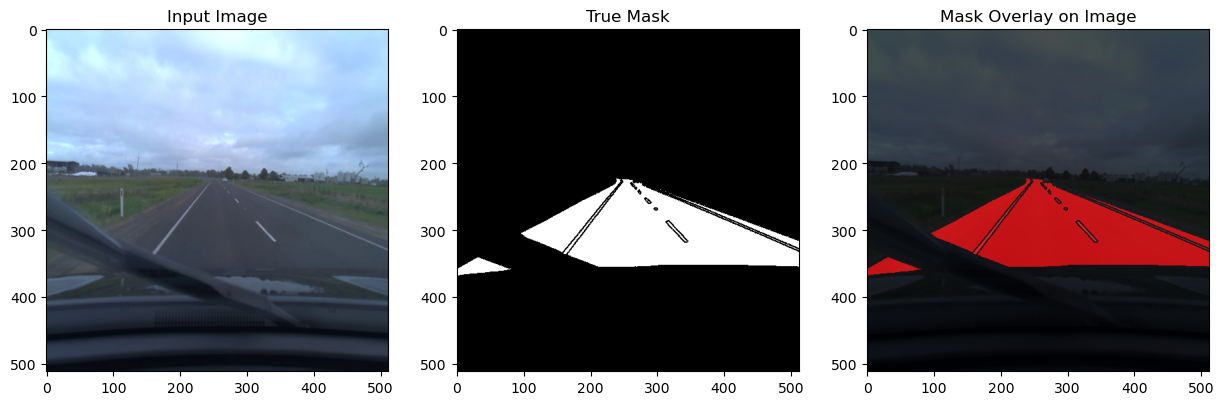

In [17]:
# Fix for OpenMP conflict
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
torch.set_num_threads(1)

# Function to overlay mask on the input image
def overlay_mask_on_image(image, mask, alpha=0.7):
    # Move the image and mask to the CPU and detach from the computation graph
    image = image.cpu().detach()
    mask = mask.cpu().detach()

    # Ensure mask is 2D for overlay
    if mask.dim() == 3 and mask.size(0) == 1:
        mask = mask.squeeze(0)

    # Normalize image (if needed) to be in the range [0, 1]
    image = image.permute(1, 2, 0)  
    image = (image - image.min()) / (image.max() - image.min())

    # Convert the mask to RGB for overlaying
    mask_rgb = torch.stack([mask, torch.zeros_like(mask), torch.zeros_like(mask)], dim=-1)

    # Overlay: blend the mask and image using alpha
    overlay = (1 - alpha) * image + alpha * mask_rgb

    return overlay

# Sample visualization function
def display_sample(image, mask):
    # Move the image and mask to the CPU and detach from the computation graph
    image = image.cpu().detach()
    mask = mask.cpu().detach()

    # Squeeze the mask if it has an extra dimension
    if mask.dim() == 3 and mask.size(0) == 1:
        mask = mask.squeeze(0)

    # Create figure with three subplots: image, mask, overlay
    fig, ax = plt.subplots(1, 3, figsize=(15, 15))

    # Plot the input image
    ax[0].imshow(image.permute(1, 2, 0))
    ax[0].set_title('Input Image')

    # Plot the mask (ensure it's 2D for grayscale)
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('True Mask')

    # Create and plot the overlay image
    overlay = overlay_mask_on_image(image, mask)
    ax[2].imshow(overlay)
    ax[2].set_title('Mask Overlay on Image')

    plt.show()

# Display a sample from the dataset to confirm it's working correctly
for images, masks in train_loader:
    print(f"Image Shape: {images.shape}") 
    print(f"Mask Shape: {masks.shape}")
    display_sample(images[0], masks[0])
    break

**Network**

In [18]:
class Modified_VGG(nn.Module):
    def __init__(self):
        super(Modified_VGG, self).__init__()
        
        # Load pretrained VGG16 and extract the convolutional layers (encoder)
        vgg16 = models.vgg16()
        vgg16.load_state_dict(torch.load("/DML/vgg16-397923af.pth"))
        self.encoder = vgg16.features
        
        # Define decoder layers (upsampling)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),  # Upconv 1 (from 32x32 -> 64x64)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # Upconv 2 (from 64x64 -> 128x128)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),   # Upconv 3 (from 128x128 -> 256x256)
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=1),                        # Final output (binary map)
            nn.Upsample(size=(512, 512), mode='bilinear', align_corners=True)  # Resize to 512x512
        )
    
    def forward(self, x):
        # Encode using VGG16 (backbone)
        x = self.encoder(x)
        
        # Decode to produce segmentation map
        x = self.decoder(x)
        
        # No activation (e.g., sigmoid) here since we will use BCEWithLogitsLoss
        return x

In [ ]:
class DLResNet101(nn.Module):
    def __init__(self, chkpt_dir="models"):
        super(DLResNet101,self).__init__()
        self.file = os.path.join(chkpt_dir, "segnet_v2")
        self.base_model = torchvision.models.segmentation.deeplabv3_resnet101(False, num_classes=5)

    def forward(self,x):
        return self.base_model(x)['out']

    def save(self):
        torch.save(self.state_dict(), self.file)

    def load(self):
        self.load_state_dict(torch.load(self.file))